# **MUSIC RECOMMENDATION**

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

In [3]:
import string
import math
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.0 MB/s eta 0:00:00


In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import lightgbm as lgbm
import xgboost as xgb
import catboost as cb

In [36]:
import py7zr

In [14]:
songs_df = pd.read_csv("/content/songs.csv")
song_extra_df = pd.read_csv('/content/song_extra_info.csv')
members_df = pd.read_csv("/content/members.csv")
train_df = pd.read_csv("/content/train.csv", nrows = 100000)

In [15]:
songs_df.head()


,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [16]:
train_df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1.0


In [17]:
song_extra_df.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


In [18]:
members_df.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [19]:
merge_1 = pd.merge(train_df, songs_df, on = 'song_id', how = 'left')
merge_2 = pd.merge(merge_1, song_extra_df, on = 'song_id', how = 'left')
songs = pd.merge(merge_2, members_df, on = 'msno', how = 'left')
del train_df, songs_df, song_extra_df, members_df, merge_1, merge_2
songs.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Good Grief,GBUM71602854,1,0,NaN,7,20120102,20171005
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,24,female,9,20110525,20170911
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,13,24,female,9,20110525,20170911
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Disco Africa,GBUQH1000063,13,24,female,9,20110525,20170911
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Sleep Without You,QM3E21606003,1,0,NaN,7,20120102,20171005


In [20]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23372 entries, 0 to 23371
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   msno                    23372 non-null  object 
 1   song_id                 23372 non-null  object 
 2   source_system_tab       23295 non-null  object 
 3   source_screen_name      22650 non-null  object 
 4   source_type             23315 non-null  object 
 5   target                  23371 non-null  float64
 6   song_length             12010 non-null  float64
 7   genre_ids               11837 non-null  object 
 8   artist_name             12010 non-null  object 
 9   composer                9509 non-null   object 
 10  lyricist                7172 non-null   object 
 11  language                12010 non-null  float64
 12  name                    14865 non-null  object 
 13  isrc                    13634 non-null  object 
 14  city                    23372 non-null

In [21]:
songs.shape

(23372, 20)

In [22]:
songs.isnull().sum()

msno                          0
song_id                       0
source_system_tab            77
source_screen_name          722
source_type                  57
target                        1
song_length               11362
genre_ids                 11535
artist_name               11362
composer                  13863
lyricist                  16200
language                  11362
name                       8507
isrc                       9738
city                          0
bd                            0
gender                     9034
registered_via                0
registration_init_time        0
expiration_date               0
dtype: int64

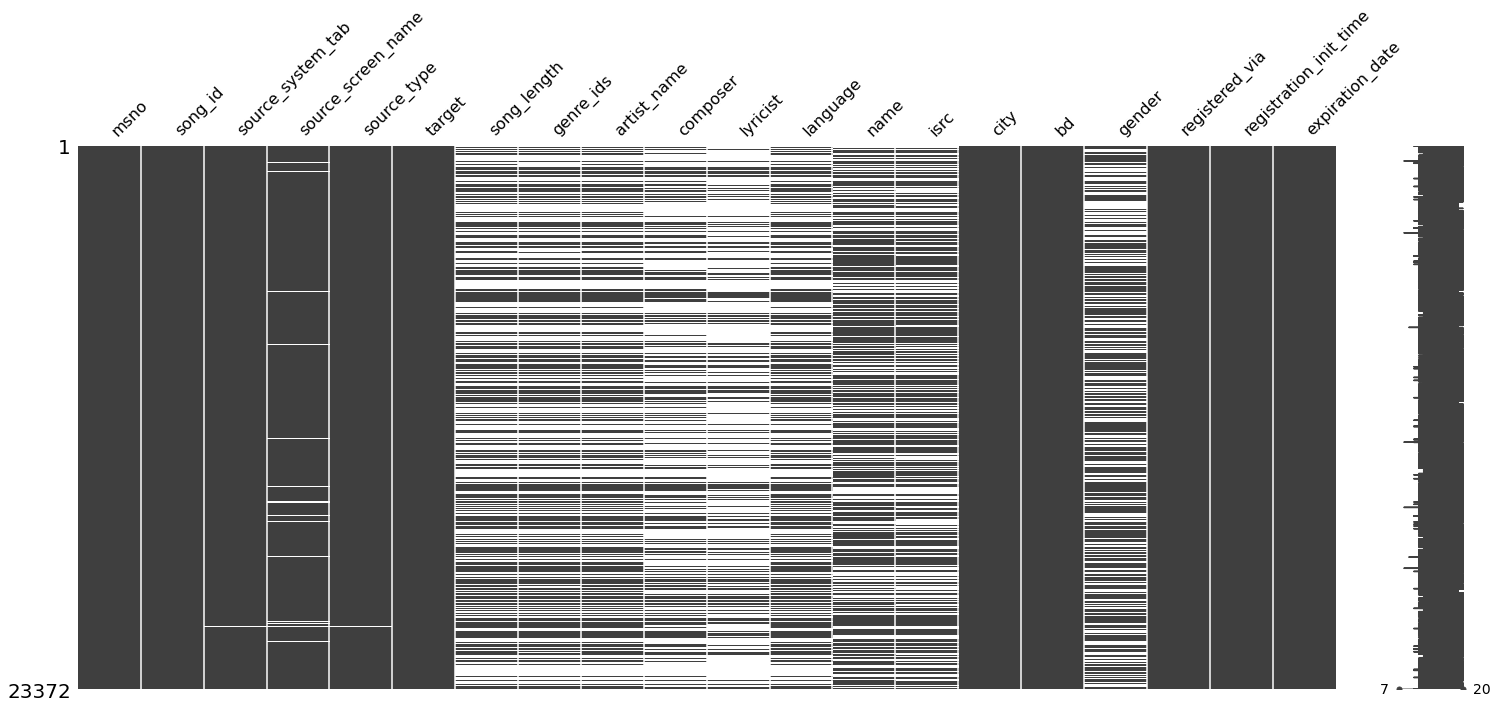

In [23]:
msno.matrix(songs)

In [24]:
for i in songs.select_dtypes(include=['object']).columns:
    songs[i][songs[i].isnull()] = 'unknown'
songs.fillna(value = 0).tail()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
23367,l+XhyQlVXQWoIm9R7VTLkIw1ZvLmeTbtb9YA7c56A5E=,THqGcrzQyUhBn1NI/+Iptc1vKtxBIEg0uA8iaoJnO1Q=,discover,unknown,online-playlist,1.0,218592.0,465,玖壹壹,陳皓宇,廖建至 洪瑜鴻 陳皓宇,3.0,嘻哈庄腳情,TWA451500402,1,0,unknown,7,20140315,20170914
23368,QSr0tiC4PPRruETvyxfr74vv30ktUllcniDmfpm43+g=,uAIiZqdh0tWa6zWe+9cY47RD2DltaWTKsgb+3nMWhKM=,my library,Local playlist more,local-library,1.0,310230.0,465,Ai Otsuka (大塚愛),unknown,unknown,17.0,unknown,unknown,1,0,unknown,7,20160220,20170920
23369,5oYD7fTQeV3mPxctMT+K420qGMOVst1Zss0vgfW2rUA=,SdJcEGZG3drskIGYwwmfAc1+0fWuJHxs3deaWN+gXSI=,discover,Online playlist more,online-playlist,0.0,0.0,unknown,unknown,unknown,unknown,0.0,一直想著他,CNF181301828,1,0,unknown,4,20160615,20170101
23370,/z/6dbv3kR9Wzn2PgnYUulEKHh8vc/kDxjmXTxS6wmE=,IS08PctmOw60RY3SOCTDLcb7CoDrF88koxmYKJ2z1b4=,discover,Discover Feature,song-based-playlist,1.0,261250.0,465,Bruno Mars,unknown,unknown,52.0,Versace On The Floor,USAT21603250,1,18,unknown,13,20160926,20171019
23371,5oYD7fTQeV3mPxctMT+K420qGMOVst1Zss0vgfW2rUA=,PHyXmZoeq2/,unknown,unknown,unknown,0.0,0.0,unknown,unknown,unknown,unknown,0.0,unknown,unknown,1,0,unknown,4,20160615,20170101


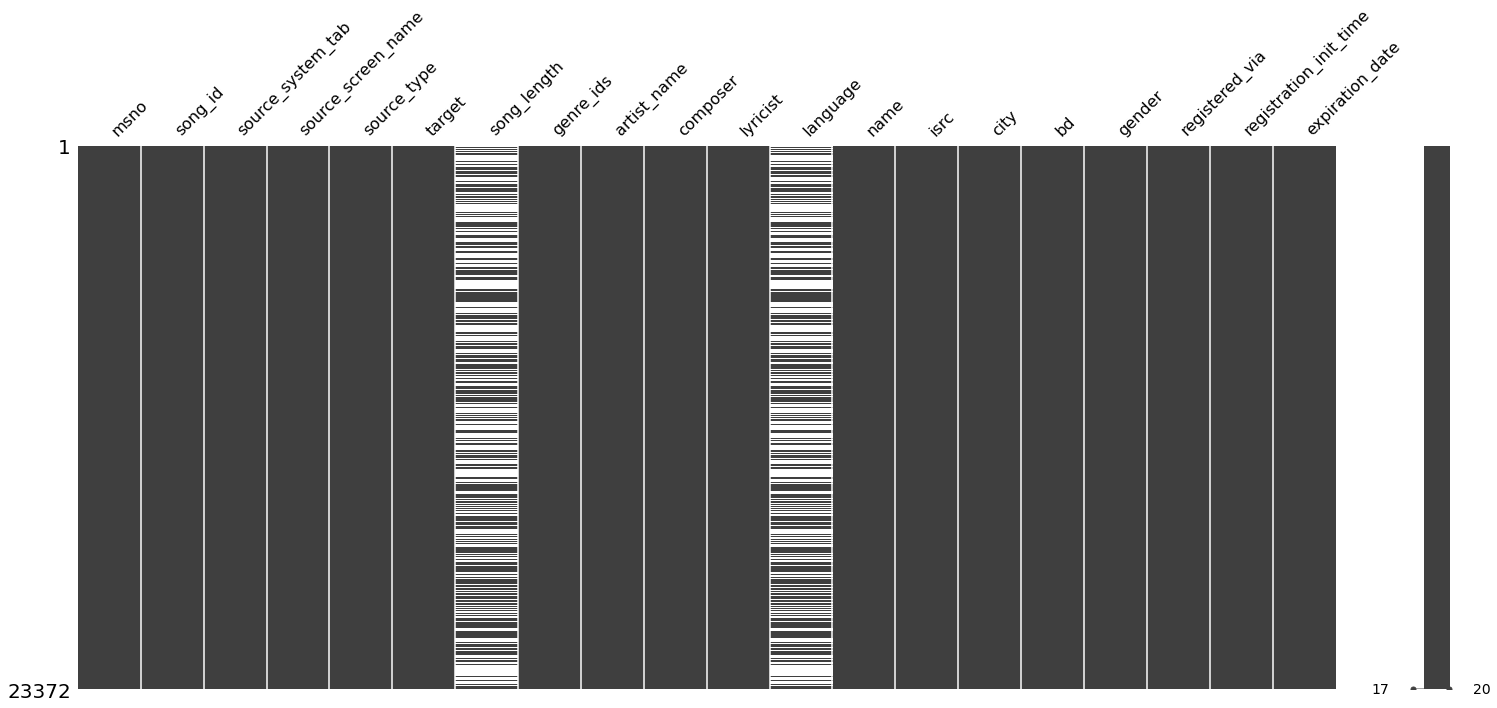

In [25]:
msno.matrix(songs)

In [26]:
# registration_init_time
songs.registration_init_time = pd.to_datetime(songs.registration_init_time, format='%Y%m%d', errors='ignore')
songs['registration_init_time_year'] = songs['registration_init_time'].dt.year
songs['registration_init_time_month'] = songs['registration_init_time'].dt.month
songs['registration_init_time_day'] = songs['registration_init_time'].dt.day

# expiration_date
songs.expiration_date = pd.to_datetime(songs.expiration_date,  format='%Y%m%d', errors='ignore')
songs['expiration_date_year'] = songs['expiration_date'].dt.year
songs['expiration_date_month'] = songs['expiration_date'].dt.month
songs['expiration_date_day'] = songs['expiration_date'].dt.day

In [27]:
songs.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1.0,NaN,unknown,unknown,unknown,unknown,NaN,Good Grief,GBUM71602854,1,0,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1.0,NaN,unknown,unknown,unknown,unknown,NaN,unknown,unknown,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1.0,NaN,unknown,unknown,unknown,unknown,NaN,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1.0,NaN,unknown,unknown,unknown,unknown,NaN,Disco Africa,GBUQH1000063,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1.0,NaN,unknown,unknown,unknown,unknown,NaN,Sleep Without You,QM3E21606003,1,0,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5


In [28]:
label_encoder = LabelEncoder()
one_hot = OneHotEncoder()

for i in songs.columns :
    songs[i] = label_encoder.fit_transform(songs[i])

In [29]:
songs.head()


,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,739,2284,1,6,5,1,3607,94,1031,1756,820,8,864,612,0,0,2,2,693,240,8,0,1,1,9,4
1,1512,6754,3,7,4,1,3607,94,1031,1756,820,8,2819,5876,11,11,0,3,547,216,7,4,24,1,8,10
2,1512,3644,3,7,4,1,3607,94,1031,1756,820,8,959,5528,11,11,0,3,547,216,7,4,24,1,8,10
3,1512,719,3,7,4,1,3607,94,1031,1756,820,8,593,621,11,11,0,3,547,216,7,4,24,1,8,10
4,739,1043,1,6,5,1,3607,94,1031,1756,820,8,2115,1936,0,0,2,2,693,240,8,0,1,1,9,4


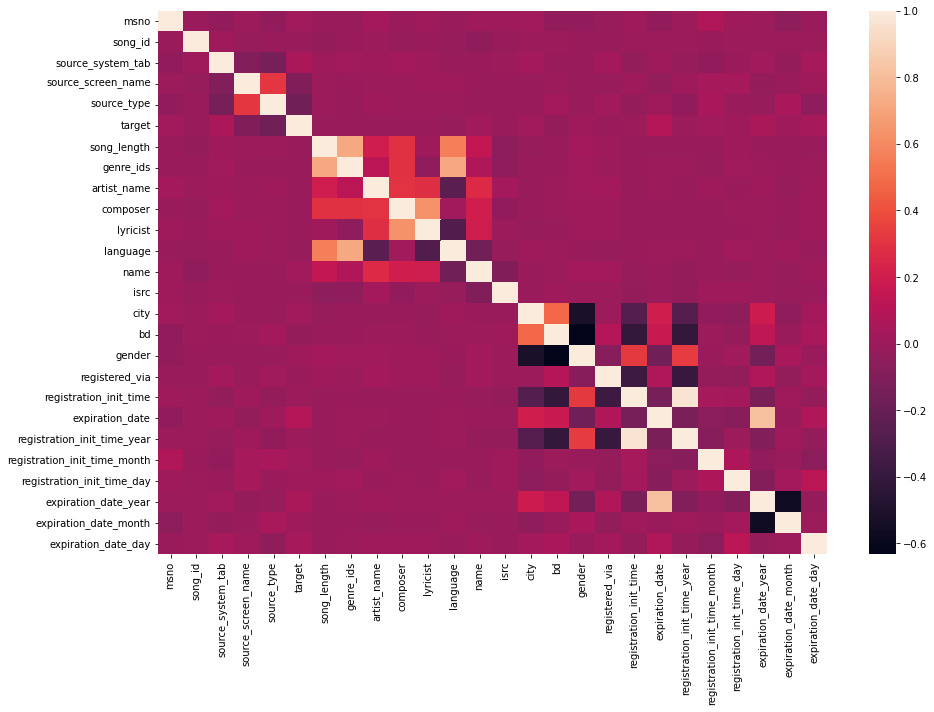

In [30]:
# Сorrelation matrix
plt.figure(figsize=[15,10])
sns.heatmap(songs.corr()) #annot = True
plt.show()

In [31]:
songs.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'song_length', 'genre_ids', 'artist_name',
       'composer', 'lyricist', 'language', 'name', 'isrc', 'city', 'bd',
       'gender', 'registered_via', 'registration_init_time', 'expiration_date',
       'registration_init_time_year', 'registration_init_time_month',
       'registration_init_time_day', 'expiration_date_year',
       'expiration_date_month', 'expiration_date_day'],
      dtype='object')

In [32]:
X = songs.drop('target', axis = 1)
y = songs['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [37]:
rf = RandomForestClassifier(
        n_estimators = 1000,
        class_weight={0: 1.0050505050505052, 1: 0.9949494949494948}
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1.0050505050505052,
                                     1: 0.9949494949494948},
                       n_estimators=1000)

In [38]:
val_pred = rf.predict(X_val)
print("Accuracy :", accuracy_score(y_val, val_pred))

Accuracy : 0.8403217525243881


In [39]:
# without classweights
rf = RandomForestClassifier(
        n_estimators = 1000
)
rf.fit(X_train, y_train)
val_pred = rf.predict(X_val)
print("Accuracy :", accuracy_score(y_val, val_pred))

Accuracy : 0.8394660277254835
